### 支持代码生成，图表生成和文字分析，对模糊命令上下文指令匹配，对报错代码纠正重新生成等功能

生成的代码是：
```python
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('LLM_test.csv')

# 将Sales列转换为数值类型
df['Sales'] = df['Sales'].replace('[\$,]', '', regex=True).astype(float)

# 筛选出Clothing类别的数据
clothing_sales = df[df['Category'] == 'Clothing']

# 按年份分组并计算销售总额
yearly_sales = clothing_sales.groupby('Year')['Sales'].sum()

# 绘制销售总额随时间变化的趋势图
plt.figure(figsize=(10, 6))
yearly_sales.plot(kind='line', marker='o')
plt.title('Clothing Sales Total Over Time')
plt.xlabel('Year')
plt.ylabel('Total Sales ($)')
plt.grid(True)
plt.show()
```


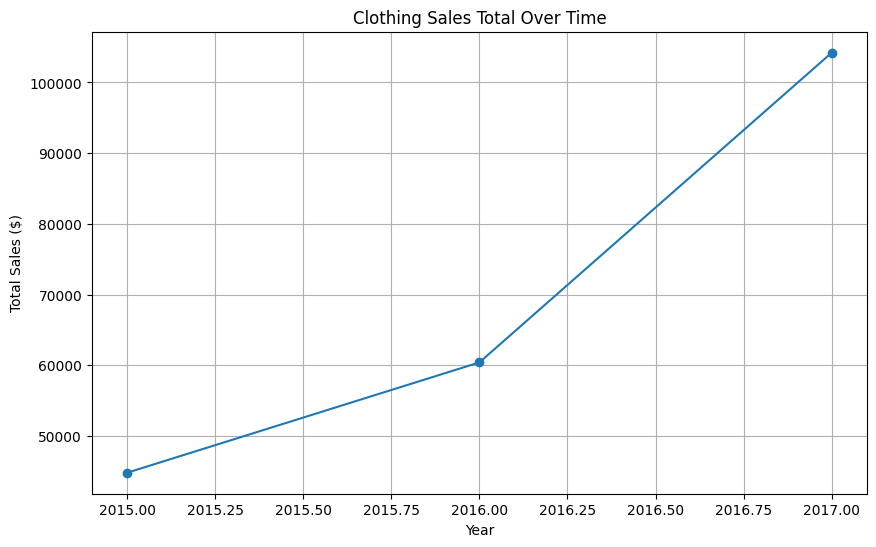

执行结果：
{'pd': <module 'pandas' from 'd:\\python\\Lib\\site-packages\\pandas\\__init__.py'>, 'plt': <module 'matplotlib.pyplot' from 'C:\\Users\\Lenovo\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\pyplot.py'>, 'df':     Year    Category        Product    Sales Rating
0   2017  Components         Chains  20000.0    75%
1   2015    Clothing          Socks   3700.0    22%
2   2017    Clothing     Bib-Shorts   4000.0    22%
3   2015    Clothing         Shorts  13300.0    56%
4   2017    Clothing         Tights  36000.0   100%
..   ...         ...            ...      ...    ...
70  2016    Clothing         Tights  22100.0    99%
71  2017  Components        Saddles   3100.0    42%
72  2015    Clothing           Caps    500.0    50%
73  2017       Bikes  Touring Bikes   3100.0    22%
74  2015  Components         Chains   8700.0    92%

[75 rows x 5 columns], 'clothing_sales':     Year  Category     Product    Sales Rating
1   2015  Clothing       Socks   3700.0    22%
2   20

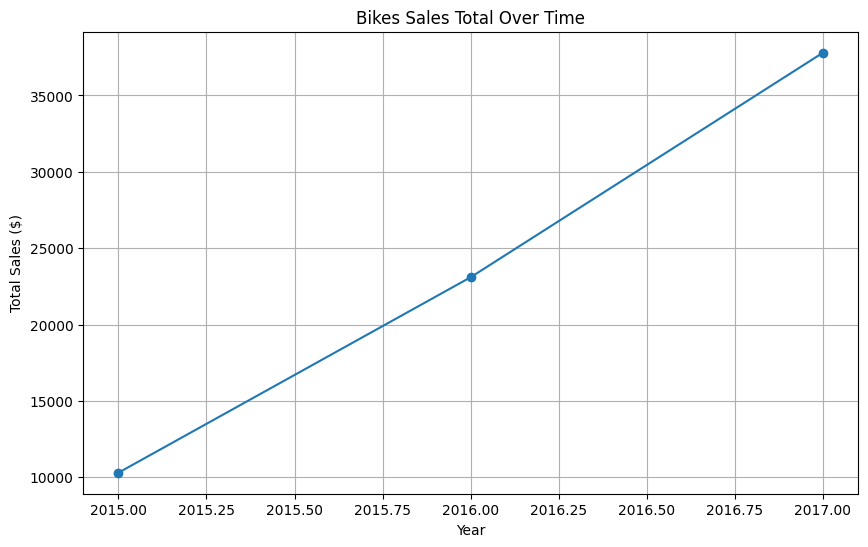

执行结果：
{'pd': <module 'pandas' from 'd:\\python\\Lib\\site-packages\\pandas\\__init__.py'>, 'plt': <module 'matplotlib.pyplot' from 'C:\\Users\\Lenovo\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\pyplot.py'>, 'df':     Year    Category        Product    Sales Rating
0   2017  Components         Chains  20000.0    75%
1   2015    Clothing          Socks   3700.0    22%
2   2017    Clothing     Bib-Shorts   4000.0    22%
3   2015    Clothing         Shorts  13300.0    56%
4   2017    Clothing         Tights  36000.0   100%
..   ...         ...            ...      ...    ...
70  2016    Clothing         Tights  22100.0    99%
71  2017  Components        Saddles   3100.0    42%
72  2015    Clothing           Caps    500.0    50%
73  2017       Bikes  Touring Bikes   3100.0    22%
74  2015  Components         Chains   8700.0    92%

[75 rows x 5 columns], 'bikes_sales':     Year Category         Product    Sales Rating
8   2016    Bikes  Mountain Bikes   6300.0    40%
16 

In [2]:
from openai import OpenAI
import pandas as pd

# 使用Deepseek完成CSV分析任务
client = OpenAI(api_key="这里是我的DeepseekAPI，运行前请填充好", base_url="https://api.deepseek.com")

conversation_history = []

# 读取数据
def load_csv(file_path):
    try:
        data = pd.read_csv(file_path)
        data['Year'] = pd.to_datetime(data['Year']) 
        return data
    except Exception as e:
        return f"Error loading data: {e}"

# 清理返回的代码中的非法字符（如中文引号，全角逗号）
def clean_code(code):
    # 替换中文引号和全角字符为对应的英文字符
    code = code.replace('“', '"').replace('”', '"')
    code = code.replace('，', ',')
    # 清理生成的代码，去掉 ```python 和 ```
    code = code.strip("```python\n")  # 去掉开头的 ```python 和换行符
    code = code.strip("```")  # 去掉结尾的 ```
    return code

# 使用DeepSeek-chat的API生成Python代码
def generate_code_from_query(query,context,content):
    global conversation_history
    
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": "你是一个非常擅长处理CSV类型文件数据的Python代码工程师.在生成回答时，你只需要输出解决问题的Python代码，不需要解释。请你根据user提出的要求后，Lets think step by step，对任务逐步思考后，来输出能够完成对应分析任务和绘制相应图像的python代码.用户会对一个文件进行一系列的分析，所以你需要记住前面提问的细节"},
            {"role": "user", "content": f"我希望你完成的任务是{query}，其中我的数据保存在{context}这个路径中的.CSV文件里,具体的数据内容是{content}"},*conversation_history, 
        ],
        stream=False
    )
    conversation_history.append({"role": "user", "content": query})
    # 获取生成的 Python 代码
    generated_code = response.choices[0].message.content
    print("生成的代码是：")
    print(generated_code)  # 打印生成的代码
    conversation_history.append({"role": "assistant", "content": generated_code})
    return clean_code(generated_code)

# 执行生成的 Python 代码
def execute_python_code(python_code, context):
    try:
        local_vars = {}
        exec(python_code, {}, local_vars)
        return local_vars, None  # 返回执行结果和无错误
    except Exception as e:
        return None, f"Error executing code: {e}"  # 如果发生错误，返回错误信息

# 向 API 反馈错误并获取新的代码
def fix_code_with_api(query,code,error_message):
    global conversation_history
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": "你是一个Python专家，专门帮助修正生成的Python代码。"},
            *conversation_history,
            {"role": "user", "content": f"请你检查你之前所写的代码，并修正以下错误：{error_message}后重新生成完整的新的分析代码继续完成给定的任务以下是之前生成的代码：\n{code}。任务是：{query}。请重新生成完整的新的分析代码继续完成给定的任务，在生成回答时，你只需要输出能够完成分析的Python代码，不需要额外计算平均值等操作以及文字解释。"},
        ],
        stream=False
    )
    # 获取修正后的代码
    generated_code = response.choices[0].message.content
    #print(clean_code(generated_code))
    conversation_history.append({"role": "assistant", "content": generated_code})
    return clean_code(generated_code)

# 生成自然语言解释
def generate_explanation(execution_results, query):
    explanation_prompt = f"根据以下数据分析任务的结果，请提供一段自然语言解释：任务: {query}\n结果: {execution_results}"
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": "你是一个数据分析师，负责根据Python代码执行结果生成自然语言解释。"},
            {"role": "user", "content": explanation_prompt},
        ],
        stream=False
    )
    explanation = response.choices[0].message.content
    return explanation

# 检查常见错误
def check_for_input_errors(query):
    common_errors = {
        "clothing": "Clothing",
        "bikes": "Bikes",
        "components": "Components",
        "accessories": "Accessories",
    }
    
    for error, correct in common_errors.items():
        if error in query.lower():
            query = query.replace(error, correct)
    
    return query

# 生成合理的错误反馈，并要求用户重新输入
def validate_and_request_input(file_path, query):
    # 如果CSV文件读取失败，要求重新输入
    data = load_csv(file_path)
    if isinstance(data, str):  # 如果加载数据时发生错误
        print(f"错误：{data}")
        return None
    
    # 检查并修正可能的输入错误
    corrected_query = check_for_input_errors(query)
    
    # 判断查询是否能匹配到数据内容
    #if "Clothing" not in corrected_query and "Bikes" not in corrected_query and "Components" not in corrected_query and "Accessories" not in corrected_query:
    #    print("无法识别该类别，是否输入有误？请重新输入一个有效的查询。")
    #    return None
    
    return corrected_query

# 示例：处理一个分析任务
def analyze_data(file_path, query):
    # 请求用户输入，并校验
    corrected_query = validate_and_request_input(file_path, query)
    
    # 如果输入无效，则返回并重新请求输入
    if corrected_query is None:
        return "输入无效，请重新尝试。"

    # 生成代码
    python_code = generate_code_from_query(corrected_query,file_path,pd.read_csv(file_path))

    # 执行生成的代码
    execution_results, error_message = execute_python_code(python_code, pd.read_csv(file_path))

    # 如果执行过程中有错误，向 API 请求修正代码
    while error_message:
        print(f"发生错误：{error_message}")
        python_code = fix_code_with_api(corrected_query,python_code,error_message)
        execution_results, error_message = execute_python_code(python_code, pd.read_csv(file_path))

    # 生成自然语言解释
    if execution_results:
        explanation = generate_explanation(execution_results, query)
        return execution_results, explanation
    else:
        return "代码执行失败，无法生成结果和解释。"

# 主程序，支持命令行输入查询
def main():
    file_path = input("请输入CSV文件路径：")  # 让用户输入文件路径
    while True:
        query = input("请输入数据分析问题：")  # 让用户输入问题
        if query.lower() in ['exit', 'quit', '退出']:  # 用户输入'退出'时结束
            print("退出程序.")
            break
        
        # 执行分析并输出结果
        execution_results, explanation = analyze_data(file_path, query)
        
        if "输入无效" in execution_results:  # 如果输入无效，则让用户重新输入
            continue

        print("执行结果：")
        print(execution_results)
        
        print("解释：")
        print(explanation)

# 运行主程序
if __name__ == "__main__":
    main()
